# Report Description Classification

This notebook uses the new data (summarized in `preprocess/new_data_summary.ipynb`) to evaluate the models trained on the previous dataset.

> This notebook should probably not be edited as the new data will be used to train the models following the completion of this notebook.

## Data Specification

This notebook was tested with data preprocessed by `ReportData` with 432 training examples. Scrubadub description scrubbing without placeholders is used. Lemmatization in preprocessing **is not used** as it is performed in the loaded pipelines.

Commit tested at: `d49afef133ff3bdc623a2ef761fa6a6ccac6f469`

## Setup

If running this notebook in Google Colab, upload the requested files and allow the dependencies to be installed. The file paths should be treated as relative to the colab file, create any folders necessary to satisfy the paths.

Otherwise update the path to allow for necessary imports.

In [1]:
import sys

IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    from google.colab import files

    required_files = [
        "requirements.txt",
        "data-processed.csv",
        "report_data.py",
        "report_data_d.py",
        "incident_types_d.py",
        "training/description_classification/utils.py",
        "training/description_classification/model_paths.py",
    ]
    for file in required_files:
        print(f"Upload {file}")
        files.upload()

    !pip install -r requirements.txt
else:
    from os import path

    root = path.abspath(path.join("..", ".."))
    sys.path.append(root)

    preprocess = path.join(root, "preprocess")
    sys.path.append(preprocess)

    incident_types = path.join(preprocess, "incident_types")
    sys.path.append(incident_types)

In [2]:
import matplotlib.pyplot as plt
from sklearn import set_config
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.utils.class_weight import compute_sample_weight

from incident_types_d import IncidentType
from report_data import ReportData
from report_data_d import ColName
from training.description_classification import utils

set_config(display="diagram")

In [3]:
report_data = ReportData().get_processed_data()[[ColName.DESC, ColName.INC_T1]]
report_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432 entries, 0 to 431
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ColName.DESC    432 non-null    object
 1   ColName.INC_T1  432 non-null    object
dtypes: object(2)
memory usage: 6.9+ KB


## Evaluation

We will evaluate the performance of the models using the old samples as training data and the new samples as test.
> NOTE: We are assuming the models we are loading have been fitted just on the old data.

In [4]:
cnb = utils.load_cnb()
cnb

Pipeline(memory='C:\\Users\\siepp\\AppData\\Local\\Temp\\tmp3gf5lkoy',
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(min_df=2, ngram_range=(1, 2),
                                 token_pattern='\\b\\w+\\b',
                                 tokenizer=<function spacy_tokenizer at 0x000002AA6814CF70>)),
                ('complementnb', ComplementNB(alpha=1.26))])

In [5]:
svm = utils.load_svm()
svm

Pipeline(memory='C:\\Users\\siepp\\AppData\\Local\\Temp\\tmpkgwu7c3z',
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(min_df=2, ngram_range=(1, 2),
                                 token_pattern='\\b\\w+\\b',
                                 tokenizer=<function spacy_tokenizer at 0x000002AA6814CF70>)),
                ('svc',
                 SVC(C=0.3999999999999999, class_weight='balanced', coef0=1.0,
                     decision_function_shape='ovo', kernel='sigmoid'))])

In [6]:
old_total = int(sum(cnb.steps[-1][1].class_count_))
old_total

335

In [7]:
old_data = report_data[:old_total]
old_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 335 entries, 0 to 334
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ColName.DESC    335 non-null    object
 1   ColName.INC_T1  335 non-null    object
dtypes: object(2)
memory usage: 5.4+ KB


In [8]:
new_data = report_data[old_total:]
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 335 to 431
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ColName.DESC    97 non-null     object
 1   ColName.INC_T1  97 non-null     object
dtypes: object(2)
memory usage: 1.6+ KB


In [9]:
X_test = new_data[ColName.DESC]
y_test = new_data[ColName.INC_T1]
weight_test = compute_sample_weight(utils.count_weight(y_test), y_test)

Complement NB test:

Accuracy: 58.42%
Balanced accuracy: 18.89%

Classification report:

                                                             precision    recall  f1-score   support

                   Client aggression towards another person       0.03      0.25      0.06      16.0
                         Client aggression towards property       0.00      0.00      0.00      36.0
                             Concern for welfare of a child       0.62      1.00      0.76      16.0
                               Homicide (Threat or attempt)       0.00      0.00      0.00       0.0
                                          Medical emergency       0.63      1.00      0.77     676.0
                                    Mental health emergency       0.00      0.00      0.00     169.0
                                                      Other       0.67      0.33      0.44     324.0
                                           Security concern       0.00      0.00      0.00      16.0
 

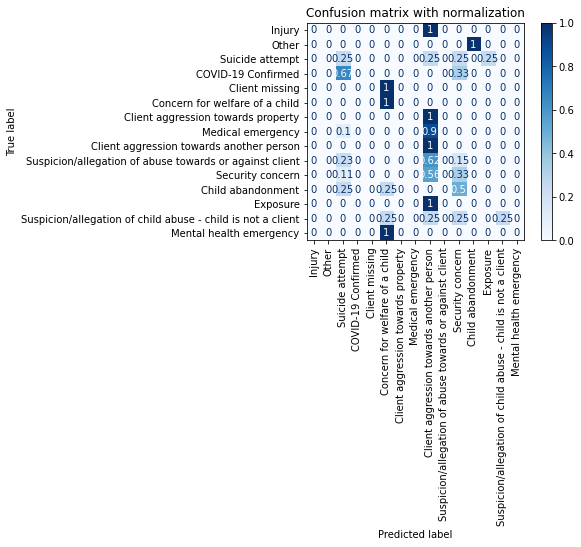

In [10]:
print('Complement NB test:\n')
utils.show_classification_report(cnb, X_test, y_test, sample_weight=weight_test)

SVM-C test:

Accuracy: 56.54%
Balanced accuracy: 18.63%

Classification report:

                                                             precision    recall  f1-score   support

                   Client aggression towards another person       0.05      0.50      0.09      16.0
                         Client aggression towards property       0.00      0.00      0.00      36.0
                             Concern for welfare of a child       0.73      1.00      0.84      16.0
                               Homicide (Threat or attempt)       0.00      0.00      0.00       0.0
                                          Medical emergency       0.64      0.96      0.77     676.0
                                    Mental health emergency       0.00      0.00      0.00     169.0
                                                      Other       0.62      0.33      0.43     324.0
                                           Security concern       0.00      0.00      0.00      16.0
         

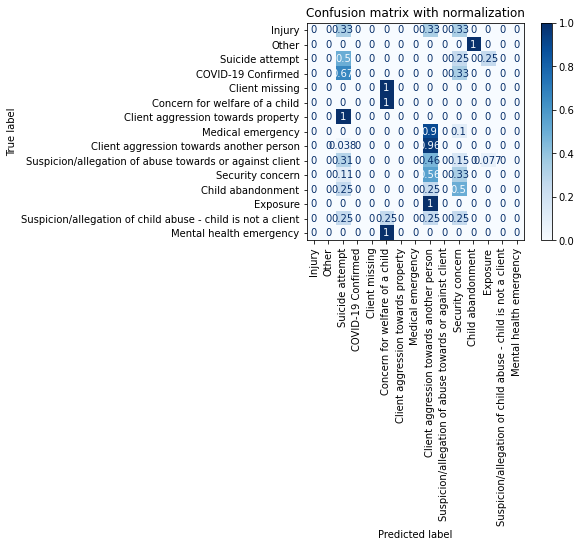

In [11]:
print('SVM-C test:\n')
utils.show_classification_report(svm, X_test, y_test, sample_weight=weight_test)